## Tokenización con Expresiones Regulares


In [3]:
%run "settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

In [4]:
import pandas as pd

file = "datos/lima-andina-articulos-con-texto.csv"
df = pd.read_csv(file)

In [5]:
df['Texto'].fillna('unkown', inplace=True)

In [6]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [7]:
import nltk
# make sure stop words are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('spanish'))

In [9]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [10]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [11]:
df['tokens'] = df['Texto'].progress_apply(prepare, pipeline=pipeline)

100%|██████████| 6575/6575 [00:00<00:00, 19338.77it/s]


In [12]:
df['num_tokens'] = df['tokens'].progress_map(len)

100%|██████████| 6575/6575 [00:00<00:00, 229659.80it/s]


## Análisis: palabras frecuentes

In [13]:
from collections import Counter

counter = Counter()

_ = df['tokens'].map(counter.update)

In [14]:
pp.pprint(counter.most_common(5))

[('centro', 4594),
 ('hoy', 4125),
 ('local', 3631),
 ('m', 3467),
 ('general', 3235)]


In [15]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [16]:
freq_df = count_words(df)
freq_df.head(5)

100%|██████████| 6575/6575 [00:00<00:00, 168466.01it/s]


,freq
token,
centro,4594
hoy,4125
local,3631
m,3467
general,3235


In [17]:
# top words with 10+ characters
count_words(df, column='Texto', 
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

100%|██████████| 6575/6575 [00:00<00:00, 27046.94it/s]


,freq
token,
institución,2427
secretario,746
presidente,735
asistencia,656
CITACIONES,605


## Diagrama de frecuencias

[Text(0.5, 0, 'Frequencia'),
 Text(0, 0.5, 'Palabra'),
 Text(0.5, 1.0, 'Pabras más frecuentes')]

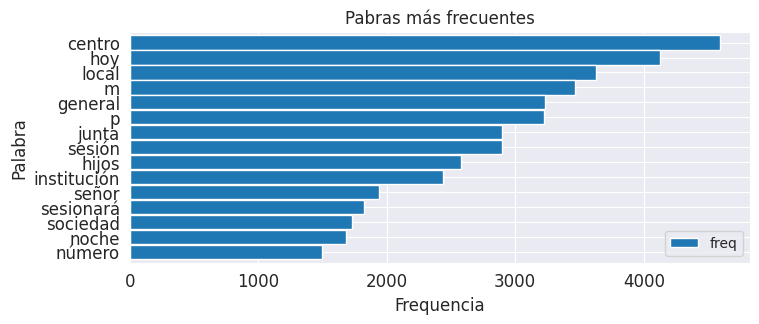

In [18]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequencia', ylabel='Palabra', title='Pabras más frecuentes')

## Nubes de palabras

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

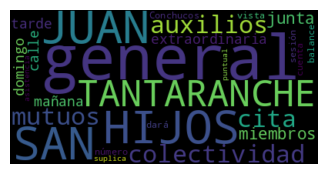

In [19]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

df['Año'] = pd.DatetimeIndex(df['Fecha']).year

text = df.query("Año==1922")['Texto'].values[0]

plt.figure(figsize=(4, 2)) ###
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [20]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

100%|██████████| 70/70 [00:00<00:00, 81038.17it/s]


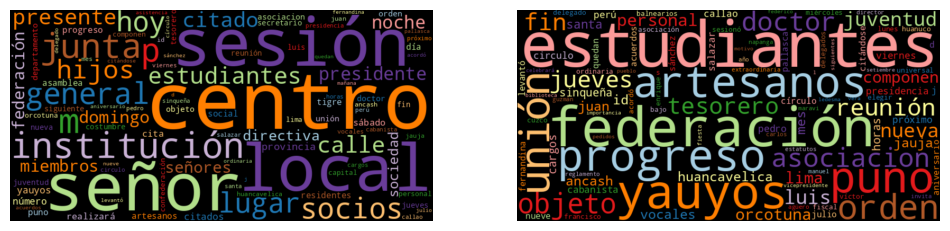

In [21]:
freq_1920_df = count_words(df[df['Año']==1920])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_1920_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_1920_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

### TF-IDF

In [22]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [23]:
idf_df = compute_idf(df)

100%|██████████| 6575/6575 [00:00<00:00, 87119.64it/s]


In [24]:
# Not in book: sample of IDF values
# high IDF means rare (interesting) term
idf_df.sample(5)

,df,idf
token,,
objetivo,4,7.50
pérez,43,5.13
comerio,2,8.20
elogio,3,7.79
yupanqui,5,7.28


In [25]:
# not in book: for more data: joining is faster
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

100%|██████████| 893/893 [00:00<00:00, 154875.68it/s]


<Figure size 1200x600 with 0 Axes>

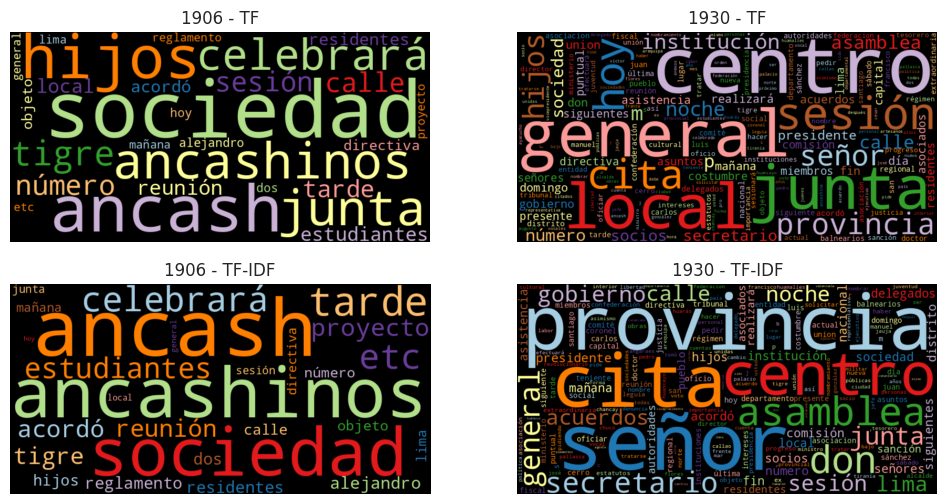

In [26]:
freq_1906 = count_words(df[df['Año'] == 1906])
freq_1930 = count_words(df[df['Año'] == 1930])

freq_1906['tfidf'] = freq_1906['freq'] * idf_df['idf']
freq_1930['tfidf'] = freq_1930['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All yeafreq_1970 = count_words(df[df['year'] == 1970])
freq_1930 = count_words(df[df['Año'] == 1930])

freq_1906['tfidf'] = freq_1906['freq'] * idf_df['idf']
freq_1930['tfidf'] = freq_1930['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_1906['freq'], title='1906 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_1930['freq'], title='1930 - TF', 
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1906['tfidf'], title='1906 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_1930['tfidf'], title='1930 - TF-IDF', 
          stopwords=['seventieth'])
plt.subplot(2,2,1)###
wordcloud(freq_1906['freq'], title='1906 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_1930['freq'], title='1930 - TF', 
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1906['tfidf'], title='1906 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_1930['tfidf'], title='1930 - TF-IDF', 
          stopwords=['seventieth'])

### Palabras clave en contexto

In [27]:
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC
    
else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

In [28]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [29]:
random.seed(22) ###
kwic(df[df['Año'] == 1930]['Texto'], 'pueblo', print_samples=20)

100%|██████████| 893/893 [00:00<00:00, 61415.96it/s]

20 random samples out of 127 contexts for 'pueblo':
sí las urgentes necesidades de los   pueblo  s vecinos. 4. Solicitar de la Marco
cipal de la escuela de varones del   pueblo   de Callahuanca. Se acordó: 1. Que 
éndose eco de los sentimientos del   pueblo   huanuqueño y traduciendo sus propi
do posesión a la comunidad de este   pueblo   de algunos terrenos, no obstante, 
de los derechos e intereses de los   pueblo  s de Pampacocha y Yaso.
sonas honradas y eliminadas por el   pueblo  , por su laborioso trabajo no tiene
uirós. Delegados en Huellas: en el   pueblo   Teodosio Martínez; y en la campiña
progreso y engrandecimiento de los   pueblo  s de la provincia de Pallasca. 3. S
parentelas al discutir asuntos del   pueblo   y la comunidad. 8. Desmentir la qu
 y que respete los derechos de los   pueblo  s de sus jurisdicciones respectivas
ada al ex presidente en nombre del   pueblo  , inmerecidamente a fin de que sea 
se interesen por el progreso de su   pueblo  , a la sesión de hoy, en

### Analizando N-grams

In [30]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [31]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change
Trigrams: the visible manifestation|visible manifestation of|manifestation of the|of the global|the global climate|global climate change


In [32]:
df['bigrams'] = df['Texto'].progress_apply(prepare, pipeline=[str.lower, tokenize]) \
                          .progress_apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(100)

100%|██████████| 6575/6575 [00:00<00:00, 201074.35it/s]


,freq
token,
p m,3103
junta general,2097
sesionará hoy,1546
centro union,663
puntual asistencia,569
...,...
centro apatino,67
recomienda puntual,67
hoy martes,66


In [43]:
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['Año'] == 1930], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

100%|██████████| 893/893 [00:00<00:00, 181468.68it/s]


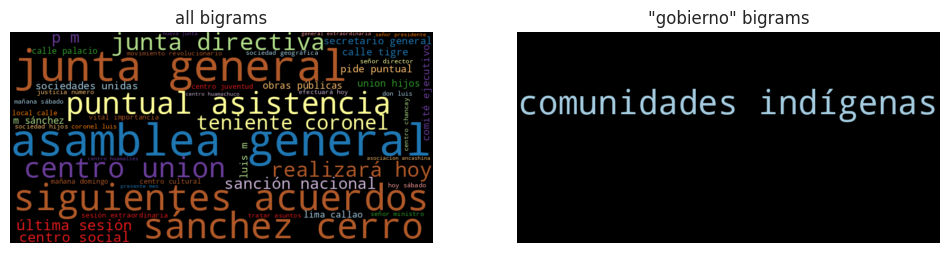

In [44]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
where = freq_df.index.str.contains('indígena')
wordcloud(freq_df[where]['freq'], title='"gobierno" bigrams', max_words=60)

### Frecuencias a lo largo del tiempo

In [45]:
def count_keywords(tokens, keywords): 
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [46]:
keywords = ['estudiantes', 'artesanos', 'gobierno', 'dictadura', 'militar', 'ejército', 'indígena']

In [47]:
def count_keywords_by(df, by, keywords, column='tokens'):
    
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
    freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [48]:
freq_df = count_keywords_by(df, by='Año', keywords=keywords)

100%|██████████| 6575/6575 [00:00<00:00, 78593.59it/s]


In [49]:
pd.options.display.max_rows = 4

In [50]:
pd.options.display.max_rows = 60

<Axes: xlabel='Año'>

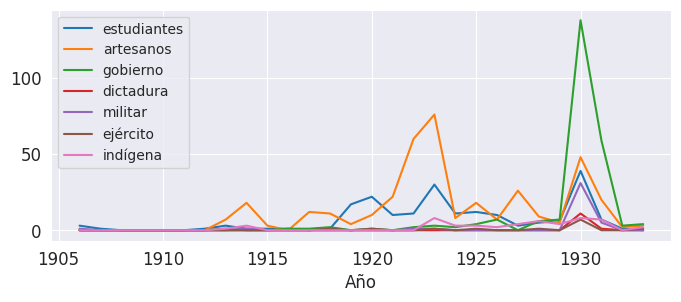

In [51]:
freq_df.plot(kind='line', figsize=(8, 3))

In [52]:
random.seed(23) ###
# analyzing mentions of 'gobierno' before 1930
kwic(df.query('Año < 1930')['Texto'], 'gobierno', window=35, print_samples=40)

100%|██████████| 4604/4604 [00:00<00:00, 121360.86it/s]

37 random samples out of 37 contexts for 'gobierno':
gido en las elecciones de junta de   gobierno  , que se realizará el domingo 27 en
 elevar un memorial al ministro de   gobierno   sobre la mala administración de la
egrama recibido en la dirección de   gobierno   y publicado en El Comercio de fech
a decidida cooperación del Supremo   Gobierno   para la ejecución de dicha carrete
nte reconocidas; 5. Que el Supremo   Gobierno   ni ninguna otra entidad responsabl
Flores al despacho del ministro de   gobierno   con el referido motivo. 3. Protest
tiones respectivas ante el supremo   gobierno   y el ministerio de fomento, la cua
los socios que forman el cuerpo de   gobierno   a sesión que se efectuará el día d
to manifestar su agradecimiento al   gobierno  , por los grandes beneficios que oc
os miembros que forman la junta de   gobierno   que la regirá en este semestre, a 
 un memorial ante el ministerio de   gobierno  , sobre cuestiones que atañen a los
o su reconocimiento oficial por el

### Analizando frecuencia de palabras con mapa de calor

100%|██████████| 6575/6575 [00:00<00:00, 75222.92it/s]


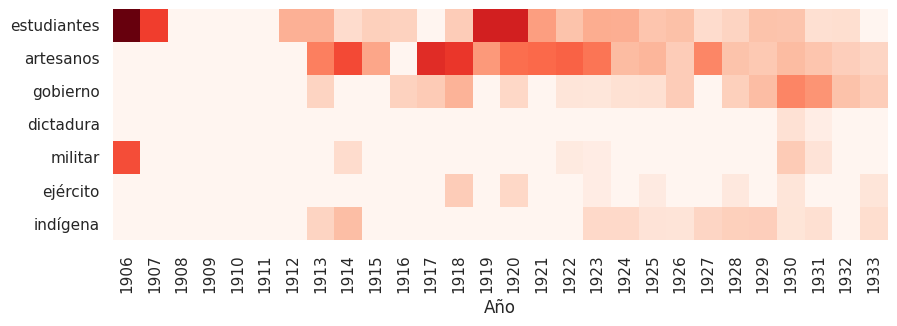

In [53]:
keywords = ['estudiantes', 'artesanos', 'gobierno', 'dictadura', 'militar', 'ejército', 'indígena']

freq_df = count_keywords_by(df, by='Año', keywords=keywords)

# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('Año')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3)) ###
sns.set(font_scale=1) ###
sns.heatmap(data=freq_df.T, 
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1) ###